# **Class 8: Part 2 - Synthetic Data Generation with LangChaing**

In [1]:
from IPython.display import Image, display
project_path = "C:/Users/tiago/OneDrive/Documentos/CapstoneProject/"

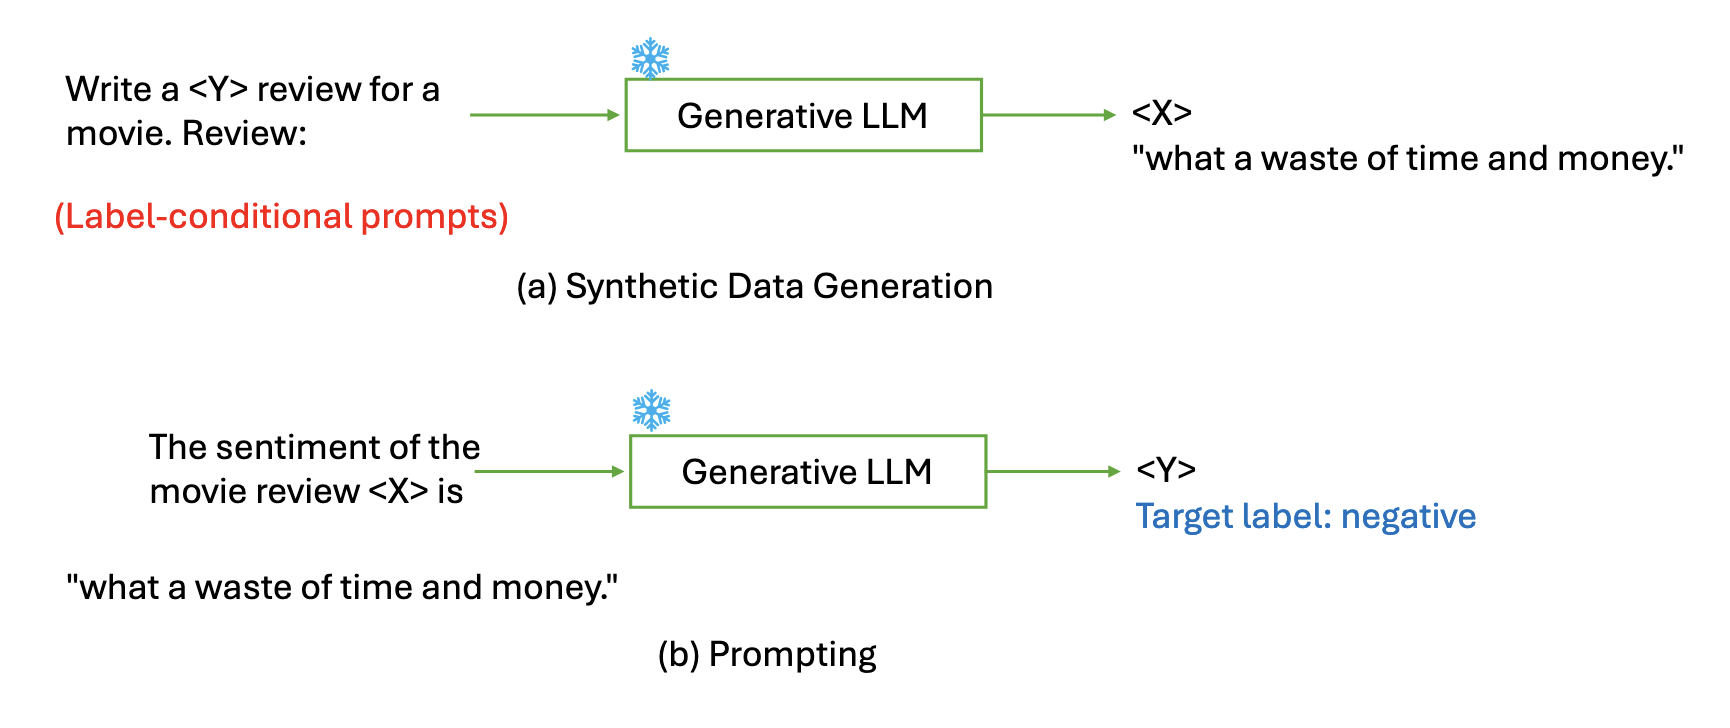

In [5]:
display(Image(filename=project_path+'images/class8/synthetic_data.png', width=600, height=800))

## Pydantic Overview:

Pydantic allows you to create classes that can automatically validate the data you pass to them.
This is helpful in various scenarios, such as API development, data parsing, and configuration management.
Example:

In [1]:
from pydantic import BaseModel

# Define a data model using Pydantic
class User(BaseModel):
    id: int
    name: str
    email: str

# Create an instance of the User model
user = User(id=1, name="John Doe", email="john.doe@example.com")

print(user)

id=1 name='John Doe' email='john.doe@example.com'


### Data Validation

In [2]:
from pydantic import BaseModel, ValidationError

class User(BaseModel):
    id: int
    name: str
    email: str

try:
    user = User(id='1', name="Jane Doe", email="jane.doe@example.com")  # Invalid id type
except ValidationError as e:
    print(e.json())  # Output error details in JSON format

### Default Values

In [3]:
class User(BaseModel):
    id: int
    name: str
    email: str = "no-reply@example.com"  # Default email

# Create a user without specifying email
user = User(id=2, name="Alice Smith")
print(user.email)  # Output: no-reply@example.com

no-reply@example.com


### Nested Models

In [4]:
from typing import List

class Address(BaseModel):
    street: str
    city: str
    country: str

class User(BaseModel):
    id: int
    name: str
    addresses: List[Address]

# Create a user with nested addresses
user = User(
    id=1,
    name="Bob",
    addresses=[
        Address(street="123 Main St", city="Anytown", country="USA"),
        Address(street="456 Side St", city="Othertown", country="USA"),
    ]
)

## OpenAI Setup:

In [3]:
from dotenv import load_dotenv
import os

# Load the OpenAI API key from the .env file
load_dotenv()
api_key = os.getenv("OPENAI_API_KEY")
if api_key is None:
    raise ValueError("The OPENAI_API_KEY environment variable is not set.")

In [4]:
if "OPENAI_API_KEY" not in os.environ:
    os.environ["OPENAI_API_KEY"] = api_key

## Langchain Setup:
LangChain is a framework for developing applications powered by large language models (LLMs).

LangChain is your ultimate ally throughout the LLM application journey:

- Develop your applications swiftly using LangChain’s open-source building blocks and convenient third-party integrations.
- Ensure seamless production with LangSmith, providing comprehensive inspection, monitoring, and evaluation capabilities for your chains.
- Effortlessly deploy your creations as APIs with LangServe, turning any chain into a powerful tool for shaping the future of language-driven applications.

Some of the use cases for LangChain are:

- Question answering with RAG
- Chatbots
- Query analysis
- Summarization
- Tagging
- **Synthetic data generation**

In [ ]:
%pip install --upgrade --quiet  langchain langchain_experimental langchain-openai

In [27]:
from langchain.prompts import FewShotPromptTemplate, PromptTemplate
from langchain_experimental.tabular_synthetic_data.openai import (
    OPENAI_TEMPLATE,
    create_openai_data_generator,
)
from langchain_experimental.tabular_synthetic_data.prompts import (
    SYNTHETIC_FEW_SHOT_PREFIX,
    SYNTHETIC_FEW_SHOT_SUFFIX,
)
from langchain_openai import ChatOpenAI

1. Define Your Data Model

Every dataset has a structure or a "schema". The MedicalBilling class below serves as our schema for the synthetic data. 

By defining this, we're informing our synthetic data generator about the shape and nature of data we expect.

In [12]:
class MedicalBilling(BaseModel):
    patient_id: int
    patient_name: str
    diagnosis_code: str
    procedure_code: str
    total_charge: float
    insurance_claim_amount: float

2. Sample Data

To guide the synthetic data generator, it's useful to provide it with a few real-world-like examples. These examples serve as a "seed" - they're representative of the kind of data you want, and the generator will use them to create data that looks similar to your expectations.

Here are some fictional medical billing records:

In [13]:
examples = [
    {
        "example": """Patient ID: 123456, Patient Name: John Doe, Diagnosis Code: 
        J20.9, Procedure Code: 99203, Total Charge: $500, Insurance Claim Amount: $350"""
    },
    {
        "example": """Patient ID: 789012, Patient Name: Johnson Smith, Diagnosis 
        Code: M54.5, Procedure Code: 99213, Total Charge: $150, Insurance Claim Amount: $120"""
    },
    {
        "example": """Patient ID: 345678, Patient Name: Emily Stone, Diagnosis Code: 
        E11.9, Procedure Code: 99214, Total Charge: $300, Insurance Claim Amount: $250"""
    },
]

3. Craft a Prompt Template

The generator doesn't magically know how to create our data; we need to guide it. We do this by creating a prompt template. 

This template helps instruct the underlying language model on how to produce synthetic data in the desired format.

In [14]:
OPENAI_TEMPLATE = PromptTemplate(input_variables=["example"], template="{example}")

prompt_template = FewShotPromptTemplate(
    prefix=SYNTHETIC_FEW_SHOT_PREFIX,
    examples=examples,
    suffix=SYNTHETIC_FEW_SHOT_SUFFIX,
    input_variables=["subject", "extra"],
    example_prompt=OPENAI_TEMPLATE,
)

The FewShotPromptTemplate includes:

    prefix and suffix: These likely contain guiding context or instructions.
    examples: The sample data we defined earlier.
    input_variables: These variables ("subject", "extra") are placeholders you can dynamically fill later. For instance, "subject" might be filled with "medical_billing" to guide the model further.
    example_prompt: This prompt template is the format we want each example row to take in our prompt.


4. Creating the Data Generator

With the schema and the prompt ready, the next step is to create the data generator. 

This object knows how to communicate with the underlying language model to generate synthetic data.


Check models pricing before choosing one: https://openai.com/api/pricing/

Take into account each group has a 5€ credit to use the API.

In [28]:
llm = ChatOpenAI(api_key=api_key, model="gpt-3.5-turbo", temperature=1)

In [29]:
synthetic_data_generator = create_openai_data_generator(
    output_schema=MedicalBilling,
    llm=llm,
    prompt=prompt_template,
)

5. Generate Synthetic Data

Finally, let's generate our synthetic data!

In [31]:
synthetic_results = synthetic_data_generator.generate(
    subject="medical_billing",
    extra="the name must be chosen at random. Make it something you wouldn't normally choose.",
    runs=5,
)

This costed less than 0.002€.

In [37]:
synthetic_results

[MedicalBilling(patient_id=246810, patient_name="Mabel O'Donnell", diagnosis_code='G47.9', procedure_code='99204', total_charge=300.0, insurance_claim_amount=240.0),
 MedicalBilling(patient_id=123456, patient_name='Bartholomew Snodgrass', diagnosis_code='N18.9', procedure_code='99214', total_charge=400.0, insurance_claim_amount=320.0),
 MedicalBilling(patient_id=777777, patient_name='Zelda Blunderbuss', diagnosis_code='I25.10', procedure_code='99213', total_charge=350.0, insurance_claim_amount=280.0),
 MedicalBilling(patient_id=135792, patient_name='Barnabas Pumpernickel', diagnosis_code='K51.9', procedure_code='99203', total_charge=250.0, insurance_claim_amount=200.0),
 MedicalBilling(patient_id=999999, patient_name='Cornelius McFiddlesticks', diagnosis_code='Z00.0', procedure_code='99205', total_charge=500.0, insurance_claim_amount=400.0),
 MedicalBilling(patient_id=123456, patient_name='Harriet Bumblefritz', diagnosis_code='G12.21', procedure_code='99214', total_charge=400.0, insura

In [38]:
type(synthetic_results[0])

__main__.MedicalBilling

# **Class 8: Part 3 - Synthetic Data Generation using AttrPrompt**

"We delve into the realm of training data generation using complex, attributed prompts, which possess
the potential to produce a wide range of diverse and attributed generated data. Specifically, we focus
on datasets characterized by diverse domains and high cardinality and class-imbalance, and our results
demonstrate the superior performance of attributed prompts compared to simple class-conditional
prompts. Furthermore, we present a comprehensive empirical study on training data generation that
covers essential aspects such as bias, diversity, and efficiency."

https://github.com/yueyu1030/AttrPrompt/tree/main

https://arxiv.org/abs/2306.15895

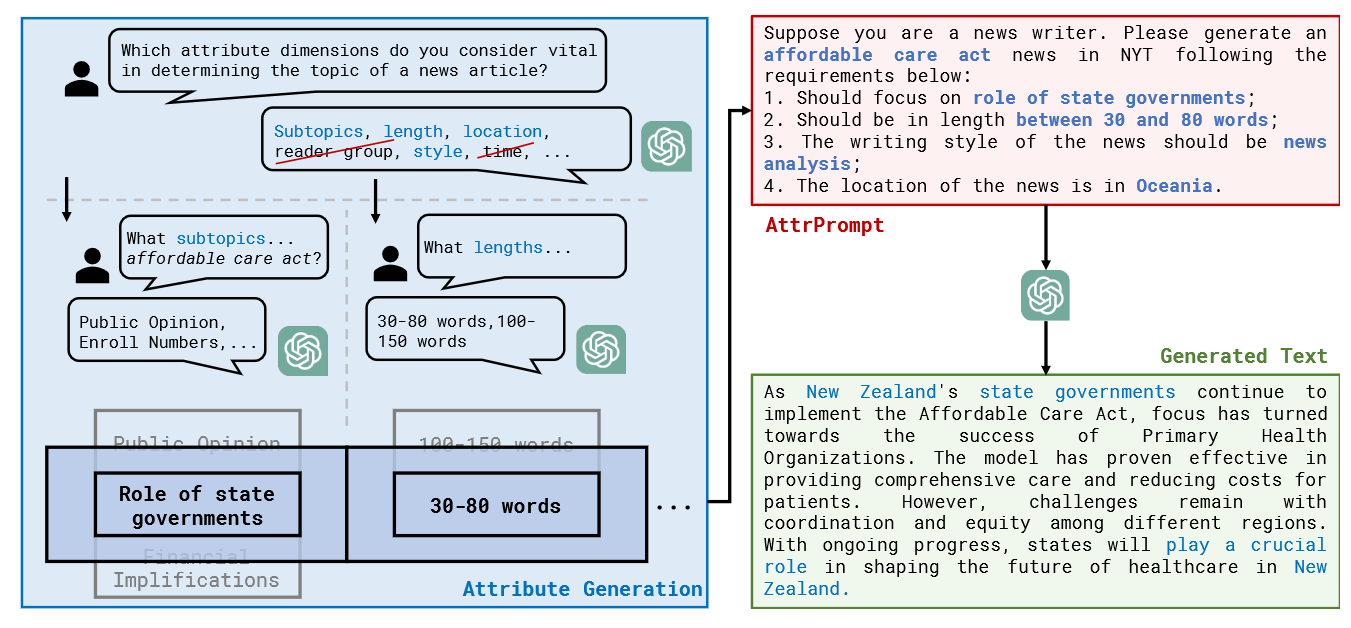

In [7]:
display(Image(filename=project_path+'images/class8/attrprompt.png', width=1000, height=800))

**We will generate synthetic dats similar to New York Times news .**

In [1]:
import json
import re
from openai import OpenAI

# Create an OpenAI API client
client = OpenAI()

# Define the parameters for the OpenAI API
model="gpt-3.5-turbo"
temperature=1.0
max_tokens=400
top_p=1.0

In [2]:
def generate_multiple_responses(messages):
    responses = []
    for message in messages:
        response = client.chat.completions.create(
            model=model,
            messages=message,
            temperature=temperature,
            max_tokens=max_tokens,
            top_p=top_p,
        )
        responses.append(response.choices[0].message.content)
    return responses

In [75]:
# Define news topics for the prompt
topics = [
    "federal_budget",
    "surveillance",
    "the_affordable_care_act",
    "immigration",
    "law_enforcement",
    "gay_rights",
    "gun_control",
    "military",
    "abortion",
    "dance",
    "tv_show",
    "music",
    "movies",
    "stocks_and_bonds",
    "energy_companies",
    "economy",
    "international_business",
    "astronomy",
    "environment",
    "hockey",
    "basketball",
    "tennis",
    "golf",
    "american_football",
    "baseball",
    "soccer"
]

1. Generating training data with simple prompts (SimPrompt) 

In [81]:
domain = 'news'
messages = []

for class_name in topics:
    prompt = re.sub("_", " ", f"Suppose you are a writer for {domain}. Please give an example of a synthetic {class_name} {domain}.")
    messages.append([{"role": "system", "content": prompt}])

In [83]:
answers = generate_multiple_responses(messages)

In [85]:
generated_data = {}

for class_name, answer in zip(topics, answers):
   generated_data[class_name] = answer

In [ ]:
print(generated_data["immigration"])

Title: New Immigration Reform Bill Proposed in Congress

In a landmark move, lawmakers in Congress have unveiled a comprehensive immigration reform bill aimed at addressing the nation's broken immigration system. The bill, titled the Secure and Inclusive Immigration Act, proposes a pathway to citizenship for millions of undocumented immigrants currently living in the United States.

Under the proposed legislation, eligible undocumented immigrants would be able to apply for legal status, provided they meet certain criteria and pass background checks. Additionally, the bill includes provisions to enhance border security and modernize the legal immigration system to better meet the needs of the economy.

Several advocacy groups and immigration experts have lauded the bill as a long-overdue step towards a more just and humane immigration policy. However, the bill's fate remains uncertain as it faces an uphill battle in Congress, where partisan divisions on immigration policy have long stym

In [90]:
# Save the generated data to a JSON file with some formatting
with open("generated_data.json", "w") as f:
    json.dump(generated_data, f, indent=4)

2. Generating training data with attributed prompts (AttrPrompt)

We recommend to use the Online ChatGPT Platform for this step since it only need one forward step. An example of the forward process is listed as follows:
    
    ```
    First input
    >  What do you think are important attributes to generate some diverse news from NYT under a specific topic, such as Football, Federal Budget. Examples: subtopics, writing style...

    Second input
    > Important attributes of news from the New York Times under a specific topic could include:

    Subtopics: exploring different angles and subtopics within the main topic can lead to a wider range of news stories.

    Writing style: varying the writing style can help to make the news stories more interesting and engaging for readers. 

    Sources: using a variety of sources, such as experts, eyewitnesses, and affected individuals, can provide different perspectives and add diversity to the news stories.

    Geographical locations: covering the topic from different geographical locations can help to show how it affects different communities and provide a global perspective.
    ```


In [96]:
# Geographical Locations by Continent
locations = [
    "North America",
    "South America",
    "Europe",
    "Africa",
    "Asia",
    "Oceania",
    "Antarctica"
]

writing_styles = [
    "Analytical",
    "Narrative",
    "Opinionated",
    "Investigative",
    "Brief and Informative",
    "Explanatory",
    "Human-interest",
    "Data-driven",
    "Historical comparison",
    "Satirical"
]

sources = [
    "Government officials",
    "Industry professionals",
    "Community leaders",
    "Nonprofit organizations",
    "Data and statistics",
    "Historical records"
]

# Store the generated data in a dictionary
additional_info = {
    "locations": locations,
    "writing_styles": writing_styles,
    "sources": sources
}

# Save the generated data to a JSON file with some formatting
with open("additional_info.json", "w") as f:
    json.dump(additional_info, f, indent=4)

In [ ]:
topics_dict = {
    "Immigration": [
        "Impact on local economies",
        "Immigration policy reform",
        "Stories of migrant families"
    ],
    "Gay Rights": [
        "LGBTQ+ rights in the workplace",
        "Legal protections for same-sex couples",
        "Global perspectives on LGBTQ+ issues"
    ],
    "Gun Control": [
        "Legislative debates on gun ownership",
        "Gun violence and public health",
        "Second Amendment interpretations"
    ],
    "Abortion": [
        "State-level restrictions and legislation",
        "Impact on women's health and access",
        "Public opinion and political activism"
    ],
    "TV Show": [
        "Popular streaming series trends",
        "Impact of reality TV on culture",
        "Representation and diversity in TV"
    ],
    "Music": [
        "Streaming and the music industry",
        "Popular genres across generations",
        "Impact of music on mental health"
    ],
    "Movies": [
        "Representation in Hollywood",
        "Box office trends and streaming",
        "Influence of international cinema"
    ],
    "Stocks and Bonds": [
        "Market volatility and investor strategies",
        "Role of bonds in retirement planning",
        "Impact of interest rates on stocks and bonds"
    ],
    "Economy": [
        "Inflation and consumer spending",
        "Global trade and economic growth",
        "Impact of fiscal policy on the economy"
    ],
    "International Business": [
        "Global supply chain disruptions",
        "Impact of trade wars and tariffs",
        "Emerging markets and foreign investment"
    ],
    "Environment": [
        "Climate change mitigation strategies",
        "Impact of pollution on biodiversity",
        "Renewable energy and sustainability"
    ],
    "Basketball": [
        "Influential players and their legacy",
        "The rise of international basketball",
        "Youth development and college basketball"
    ]
}

In [94]:
# Save the generated data to a JSON file with some formatting
with open("topics_dict.json", "w") as f:
    json.dump(topics_dict, f, indent=4)

In [99]:
label_names = list(topics_dict.keys())

In [ ]:
label_names

['Immigration',
 'Gay Rights',
 'Gun Control',
 'Abortion',
 'TV Show',
 'Music',
 'Movies',
 'Stocks and Bonds',
 'Economy',
 'International Business',
 'Environment',
 'Basketball']

1. First lets get the classes with high similarity.

In [107]:
domain = 'news'
data_source = "New York Times"
label_names = label_names
n_classes = 3
prompt = [re.sub("_", " ", f"Give {n_classes} most relevant classes related to {x} {domain} on {data_source} from the classes: {json.dumps(label_names)}. Write each class in a line, without enumeration. Do not include {x}.") for x in label_names]

In [108]:
messages = [[{"role": "user", "content": p}] for p in prompt]

In [109]:
responses = generate_multiple_responses(messages)

In [116]:
related_classes = {}

for class_name, response in zip(label_names, responses):
    related_classes[class_name] = response.split("\n")

In [117]:
related_classes

{'Immigration': ['Economy', 'International Business', 'Environment'],
 'Gay Rights': ['Immigration', 'International Business', 'Environment'],
 'Gun Control': ['Immigration', 'Economy', 'Environment'],
 'Abortion': ['Immigration', 'Economy', 'Environment'],
 'TV Show': ['Immigration', 'Movies', 'Music'],
 'Music': ['TV Show', 'Movies', 'Economy'],
 'Movies': ['TV Show', 'Music', 'Economy'],
 'Stocks and Bonds': ['Economy', 'International Business', 'Environment'],
 'Economy': ['Stocks and Bonds', 'International Business', 'Environment'],
 'International Business': ['Immigration', 'Economy', 'Environment'],
 'Environment': ['Immigration', 'Economy', 'International Business'],
 'Basketball': ['Immigration', 'Economy', 'International Business']}

In [ ]:
for classe, related in related_classes.items():
    print(f"Class: {classe}")
    print("Related classes:")
    for r in related:
        print(f"  - {r}")

In [19]:
# Save the generated data to a JSON file with some formatting
with open("related_classes.json", "w") as f:
    json.dump(related_classes, f, indent=4)

2. Let's generate attributes taking into account the classes with high similarity.

In [136]:
domain = 'news'
data_source = "New York Times" 
attribute = "subtopics"
n_sample = 3
prompt = [re.sub("_", " ", f"List {n_sample} diverse {attribute} related to {label} on {data_source}. These {attribute} should be unrelated to  {related}. ") for label, related in related_classes.items()]

In [137]:
messages = [[{"role": "user", "content": p}] for p in prompt]

In [138]:
responses = generate_multiple_responses(messages)

In [32]:
responses 

['1. Immigration policy and law enforcement in the United States\n2. Immigrant rights and advocacy efforts in local communities\n3. Impact of immigration on cultural diversity and integration in schools and neighborhoods',
 '1. LGBTQ+ Employment discrimination laws\n2. Gay adoption rights and custody battles\n3. Progress and setbacks in LGBTQ+ housing and homeless shelters',
 '1. Gun control legislation in relation to mental health policies\n2. Impact of gun control measures on marginalized communities\n3. Advocacy efforts by gun control groups and their effectiveness in passing legislation.',
 '1. Abortion access in rural communities \n2. The impact of religion on abortion rights \n3. Teenagers’ access to reproductive healthcare and abortion services',
 '1. TV Show Reviews and Critiques\n2. Behind-the-Scenes Insights and Interviews with TV Show Cast and Crew\n3. TV Show Ratings and Audience Reactions',
 '1. Music festivals in New York City \n2. Impact of streaming services on the musi

In [30]:
topics_dict2 = {}

for class_name, response in zip(label_names, responses):
    # Split the response in 
    topics_dict2[class_name] = response.split("\n")

In [31]:
# Save the generated data to a JSON file with some formatting
with open("topics_dict2.json", "w") as f:
    json.dump(topics_dict2, f, indent=4)

3. Optional filter subtopics for the class-dependent attributes.

In [6]:
# Load topics_dict2 from the JSON file
with open("topics_dict2.json", "r") as f:
    topics_dict2 = json.load(f)

In [14]:
filtered_topics_dict2 = {}

for attribute, similar_keywords in topics_dict2.items():

    prompt = [re.sub("_", " ", f"Consider {attribute}. Is it relevant to the following categories: {similar_keyword}? Return 1 for yes and 0 for no.") for similar_keyword in similar_keywords]    
    
    messages = [[{"role": "user", "content": p}] for p in prompt]

    responses = generate_multiple_responses(messages)
    
    for i, msg in enumerate(responses):
        if 'yes' in msg or '1' in msg:
            # Check if is empty
            if attribute not in filtered_topics_dict2:
                filtered_topics_dict2[attribute] = []
            filtered_topics_dict2[attribute].append(similar_keywords[i])
        else:
            print(f"{similar_keywords[i]} is not relevant to {attribute}")

In [20]:
# Save the generated data to a JSON file with some formatting
with open("filtered_topics_dict.json", "w") as f:
    json.dump(filtered_topics_dict2, f, indent=4)

4. Generate training data with attributes

In [33]:
# Load the filtered_topics_dict from the JSON file
with open("topics_dict2.json", "r") as f:
    subtopics_dict = json.load(f)

# Load the related_classes from the JSON file
with open("related_classes.json", "r") as f:
    related_classes = json.load(f)

In [ ]:
# Some additional information
length = 100
style = "Narrative"
location = "North America"
topic = "Immigration"

prompt_input = f"Give a synthetic sample of news in NYT on {topic} following the requirements below: \n\
            1. should focus on '{subtopics_dict[topic][0]}';\n \
            2. should be in length between {length} words and {length + 50} words;\n \
            3. The writing style of the news should be '{style}';\n \
            4. The location of the news should be in {location}; \n \
            5. The news must be relevant to {topic} and irrelevant to: {related_classes[topic]}."

messages = [{"role": "user", "content": prompt_input}]

In [50]:
response = client.chat.completions.create(
    model=model,
    messages=messages,
    temperature=1.0,
    max_tokens=1024,
    top_p=0.95,
)

In [ ]:
synthetic_new = response.choices[0].message.content

# Insert \n at the end of each sentence, marked by "."
synthetic_new = synthetic_new.replace(". ", ".\n")

In [59]:
topic

'Immigration'

In [58]:
subtopics_dict[topic][0]

'1. Immigration policy and law enforcement in the United States'

In [57]:
print(synthetic_new)

In a recent development in North America, the United States government has announced new changes to immigration policy and law enforcement.
The new measures aim to tighten border security and crack down on illegal immigration.
Under the new policy, stricter vetting procedures will be implemented for visa applicants, and increased resources will be allocated to border patrol agents.
Additionally, there will be a renewed focus on deporting individuals who have entered the country illegally.
This news comes amidst ongoing debates and discussions surrounding immigration reform in the United States.
Stay tuned for further updates on this evolving issue.


In [62]:
# Some additional information
length = 100
style = "Satirical"
location = "North America"
topic = "TV Show"

prompt_input = f"Give a synthetic sample of news in NYT on {topic} following the requirements below: \n\
            1. should focus on '{subtopics_dict[topic][0]}';\n \
            2. should be in length between {length} words and {length + 50} words;\n \
            3. The writing style of the news should be '{style}';\n \
            4. The location of the news should be in {location}; \n \
            5. The news must be relevant to {topic} and irrelevant to: {related_classes[topic]}."

messages = [{"role": "user", "content": prompt_input}]

In [63]:
response = client.chat.completions.create(
    model=model,
    messages=messages,
    temperature=1.0,
    max_tokens=1024,
    top_p=0.95,
)

In [64]:
synthetic_new = response.choices[0].message.content

# Insert \n at the end of each sentence, marked by "."
synthetic_new = synthetic_new.replace(". ", ".\n")

In [65]:
print(synthetic_new)

North America (NYT) - In a shocking turn of events, the latest TV show to hit the airwaves has left critics scratching their heads - and not in a good way.
The new series, titled "Reality Bites Back," has been hailed as a revolutionary take on the reality TV genre.
Unfortunately, it seems that the only thing revolutionary about this show is its ability to make viewers question their life choices.
One critic quipped, "I would rather watch paint dry than endure another episode of this mind-numbing drivel." Ouch.
Looks like this show might be in need of a reality check of its own.
